# Salary Prediction 

## Coding:
### [**Data Clean**](#1)
### [**Feature Engineer**](#2)
### [**Model Evaluation**](#3)

### Objects:
>> [**Data object**](#4)
>
>> [**Target distribution plot**](#5)
>
>> [**Feature object**](#6)
>
>> [**Model evaluation object**](#7)
>
>> [**Model tuning**](#8)
>
>> [**Model training**](#9)

In [1]:
__author__ = "Ya Yu Chen"
__email__ = "a725761@gmail.com"

## Import modules

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

<a id="1"></a>
## Data clean

In [3]:
class Data:
    
    def __init__(self, train_file, target_file, cate_col, num_col, target_col, id_col):
        self.cate_col = cate_col
        self.num_col = num_col
        self.feature_cols = cate_col + num_col
        self.target_col = target_col
        self.id_col = id_col
        self.train_feature_df = self.load_data(train_file)
        self.target_feature_df = self.load_data(target_file)
        self.train_df = self.create_clean_df(self.train_feature_df, 
                                             self.target_feature_df, target_col, id_col)
        
    def load_data(self, file_path):
        return pd.read_csv(file_path)

    def remove_null(self, data):
        return data.dropna()

    def merge_df(self, df1, df2, key):
        return pd.merge(df1, df2, on=key, how='inner')

    def clean_id_and_target(self, data, id_col, target):
        data = data.drop(id_col, axis=1)
        data = data[data[target] > 0]
        return data

    def shuffle_data(self, data):
        return shuffle(data).reset_index()

    def target_plot(self):
        plt.figure(figsize=(8,6))
        plt.subplot(121)
        sns.boxplot(self.train_df[self.target_col])
        plt.subplot(122)
        sns.distplot(self.train_df[self.target_col], bins=20)
        plt.show()
    
    def create_clean_df(self, train_object, target_object, target, key):
        train_df = self.merge_df(train_object, target_object, key)
        train_df = self.clean_id_and_target(train_df, key, target)
        train_df = self.shuffle_data(train_df)
        return train_df

<a id="2"></a>
## Feature engineer

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

In [5]:
class FeatureEngineer:
    
    def __init__(self, data):
        self.data = data
        self.cate_col = data.cate_col
        self.num_col = data.num_col
        self.features = self.cate_col + self.num_col
        self.target_col = data.target_col
        self.train_df = data.train_df
        self._ = self._transform_label_encoder(self.train_df, self.features)
        self.groups = self.train_df.groupby(by=self.cate_col)
        self.new_df = self._add_new_features()        
        
    def one_hot_encoding(self, data, col):
        return pd.get_dummies(data[col])    
    
    def Label_encoder(self, data, col):
        le = LabelEncoder()
        le.fit(data[col])
        data[col] = le.transform(data[col])    
        
    def _transform_label_encoder(self, data, cols):
        for col in cols:
            self.Label_encoder(data, col)
            
    def _feature_groups_df(self):
        #target = self.target_col
        groups_df = pd.DataFrame({'groups_mean': self.groups[self.target_col].mean()})
        groups_df['groups_max'] = self.groups[self.target_col].max()
        groups_df['groups_min'] = self.groups[self.target_col].min()
        groups_df['groups_std'] = self.groups[self.target_col].std()
        groups_df['groups_median'] = self.groups[self.target_col].median()
        #groups_df.reset_index(inplace=True)
        return groups_df

    def merge_df(self, df1, df2, key, fillna=False):
        df1 = pd.merge(df1, df2, on=key, how='left')
        if fillna:
            df1.fillna(0, inplace=True)
        return df1
    
    def _add_new_features(self):
        groups_df = self._feature_groups_df()
        groups_df.reset_index(inplace=True)
        return self.merge_df(self.train_df, groups_df, self.cate_col)
    
    def concat_df(self, df1, df2):
        return pd.concat([df1, df2], axis=1)
    
    def make_mi_scores(self, X, y):
        X = X.copy()
        #for colname in X.select_dtypes(["object", "category"]):
            #X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
        discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        return mi_scores

<a id="3"></a>
## Model evaluation

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [7]:
class ModelEvaluation:
    
    def __init__(self, feature):
        self.feature = feature
        self.train_df = feature.new_df
        self.target_col = feature.target_col
        self.input_df = self.create_input_df()
        self.models = []
        
    def create_input_df(self):
        return self.train_df.iloc[:, 2:]
    
    def add_model(self, model):
        return self.models.append(model)
    
    def _hyper_tuning_RDsearch(self, model, X, y):
        n_estimators = [int(x) for x in np.linspace(0,100,num=20)]
        max_features = [float(x/(X.shape[0])) for x in np.linspace(0,80, num=20)]
        max_depth = [int(x) for x in np.linspace(0,80, num=20)]
        max_depth.append(None)
        min_samples_split = [int(x) for x in np.linspace(0,100,num=20)]
        random_grid = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_split':min_samples_split}
        RD = RandomizedSearchCV(model, param_distributions = random_grid, pre_dispatch=4, cv=2, verbose=1, random_state=1, n_jobs=4)
        RD.fit(X, y)
        return RD.best_params_
    
    def hyper_tuning_GdsearchCV(self, model, X, y):
        best_params = self._hyper_tuning_RDsearch(model, X, y)
        n, max_f, max_d, min_s = best_params['n_estimators'], best_params['max_features'], best_params['max_depth'], best_params['min_samples_split']
        grid = {'n_estimators': [n-5, n, n+5], 'max_features': [max_f-1, max_f, max_f+1], 'max_depth': [max_d-10, max_d, max_d+10], 'min_samples_split': [min_s-2, min_s, min_s+2]}
        GD = GridSearchCV(model, param_grid= grid, cv=3, verbose=2, n_jobs=4)
        GD.fit(X, y)
        return GD.best_params_
    
    def _train_model(self, model, X, y, n_jobs, mean_mse, cv_std):
        mse = cross_val_score(model, X, y, cv=5, n_jobs=n_jobs, scoring='neg_mean_squared_error')
        mean_mse[model] = -1 *np.mean(mse)
        cv_std[model] = np.std(mse)
        return self._print_summary(model, mean_mse, cv_std)
    
    def train_model(self):
        for model in self.models:
            self._train_model(model, X, y, 4, mean_mse, cv_std)        
        
    def _print_summary(self, model, mean_mse, cv_std):
        print('\nModel:\n', model)
        print('Average MSE:\n', mean_mse[model])
        print('Standard deviation during CV:\n', cv_std[model])
        
    def _best_model(self, mean_mse):
        return min(mean_mse, key=mean_mse.get)
    
    def model_fit(self, X, y):
        model = self._best_model(mean_mse)
        return model.fit(X, y)
    
    def get_prediction(self, new_X):
        model = self.model_fit(X, y)
        prediction = model.predict(new_X)
        return prediction
    
    def create_feature_importance(self, X):
        model = self._best_model(mean_mse)
        importances = model.feature_importances_
        feature_importances_df = pd.DataFrame({'features': X.columns, 'importances': importances})
        feature_importances_df.sort_values(by='importances', ascending = False, inplace=True)
        feature_importances_df.set_index('features', inplace=True, drop=True)
        return feature_importances_df
    
    def plot_feature_importance(self):
        feature_importances_df = self.create_feature_importance(X)
        feature_importances_df.plot.bar(figsize=(10,8))
        plt.xticks(rotation=45)
        plt.show()

In [8]:
train_file = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\data\\train_features.csv'
test_file = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\data\\train_features.csv'
target_file = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\data\\train_salaries.csv'

cate_col = ['jobType', 'degree', 'major', 'industry']
num_col = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'
id_col = 'jobId'

<a id="4"></a>
### Data object

In [9]:
# create Data object
data = Data(train_file, target_file, cate_col, num_col, target_col, id_col)

<a id="5"></a>
### Target distribution plot

In [ ]:
# target distribution plot
data.target_plot()

<a id="6"></a>
### Feature object

In [10]:
# create feature object by data 
feature = FeatureEngineer(data)

In [11]:
feature.new_df.head()

,index,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,groups_mean,groups_max,groups_min,groups_std,groups_median
0,813636,COMP61,0,2,7,1,24,6,147,119.114768,214,59,26.818977,116.0
1,394462,COMP37,3,2,7,6,14,20,87,74.962764,163,31,22.404637,71.0
2,583409,COMP57,7,0,0,4,5,5,116,138.994924,224,77,27.952704,134.0
3,130203,COMP57,6,3,3,6,20,24,130,120.533181,202,61,27.082645,117.0
4,70832,COMP4,7,2,7,5,5,49,79,105.350124,202,53,25.788985,102.0


In [ ]:
# use 5000 sample as X to examine the MI scores
X = feature.new_df.iloc[:5000,2:]
y = X.pop('salary')
feature.make_mi_scores(X, y)

<a id="7"></a>
### Model evaluation object

In [12]:
# create new model evaluation object by feature
ME = ModelEvaluation(feature)

In [13]:
# ['jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis', 'groups_mean']
# as input_df

X = ME.input_df
y = X.pop('salary')

<a id="8"></a>
### Model tuning

In [ ]:
rr = RandomForestRegressor(random_state=1, verbose=0)
gbr = GradientBoostingRegressor(random_state=1, verbose=0)

In [ ]:
# use RandomizeSearchCV to find a range then use GridSearchCV to find the best hyperparameters
ME.hyper_tuning_GdsearchCV(rr, X, y)

In [ ]:
# use RandomizeSearchCV to find a range then use GridSearchCV to find the best hyperparameters
ME.hyper_tuning_GdsearchCV(gbr, X, y)

In [14]:
# using the best parameter for models
rrr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=80, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

gbrr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
    
reg = LinearRegression()
reg_poly = make_pipeline(PolynomialFeatures(), LinearRegression())

models = [rrr, gbrr, reg, reg_poly]

# add model to ME.models for later using
for model in models:
    ME.add_model(model)

<a id="9"></a>
### Model training

In [15]:
mean_mse = {}
cv_std = {}

# run each model then show mean_mse and cv_std for each model
ME.train_model()


Model:
 GradientBoostingRegressor(max_depth=7, n_estimators=40, presort='auto')
Average MSE:
 355.0923937088007
Standard deviation during CV:
 0.35400300643810556


In [16]:
ME.model_fit(X, y)

C:\Users\EllenChen\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:304: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  warnings.warn("The parameter 'presort' is deprecated and has no "


GradientBoostingRegressor(max_depth=7, n_estimators=40, presort='auto')

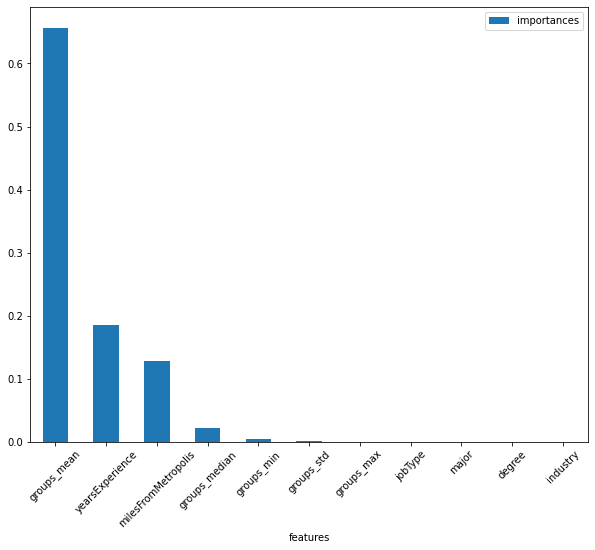

In [17]:
ME.plot_feature_importance()